# Purpose
Generate a visual of the counties that have been visited.

# Setup
## Import - Packages

In [1]:
# ---------------------------------------------------------------------------- #
# GENERAL #
import geopandas as gpd
import os
import pathlib as pl
import sys

import geopandas as gpd

# ---------------------------------------------------------------------------- #
# ANALYSIS #
import numpy as np
import pandas as pd
import siuba as s


# ---------------------------------------------------------------------------- #
# VISUALIZATION
import plotnine as p9

# ---------------------------------------------------------------------------- #
# LOCAL #
from tracking_counties.config import SEED, ROOT_DIR

## Import - Tables

In [2]:
county_path = pl.PurePath(
    ROOT_DIR, 'data', 'tables', 'list_of_counties_active.csv'
    )

dct_dtypes = {
    'state_code': str,
    'state_name': str,
    'county_code': str,
    'county_name': str,
    'visited': int,
    'geoid': str,
}

df_visited = pd.read_csv(
    county_path, 
    dtype       = dct_dtypes,
    parse_dates = ['date']
    )

/var/folders/gc/y3fn65k96hxg6x93yysw8tc00000gn/T/ipykernel_87038/3647084383.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


## Import - Shapefiles

In [3]:
sf_path = pl.PurePath(
    ROOT_DIR, 'data', 'shapefiles', '2023_county', 'tl_2023_us_county.shp'
)
df_sf = gpd.read_file(str(sf_path))

# Set clumn names to lower case
df_sf.columns = [col.lower() for col in df_sf.columns]

# Processing

## Verify Leading Zero for State and County Codes

In [6]:
# State Codes
df_visited['state_code'] = df_visited['state_code'].apply(lambda x: x.zfill(2))

# County Codes
df_visited['county_code'] = df_visited['county_code'].apply(lambda x: x.zfill(3))

## Create GEOID

In [9]:
df_visited['geoid'] = df_visited['state_code'] + df_visited['county_code']

## Join Tracking to Shapefile

In [10]:
df = (
    df_sf
    >> s.left_join(
        s._,
        df_visited,
        by = 'geoid'
    )
)

## Convert Visited to String

In [11]:
df['visited'] = df['visited'].astype(str)

## Generate Tables for Specific Plots

In [12]:
dct_plot = {}

## Contiguous US

In [13]:
# Define states that are not part of contiguous US
non_continugous_states_terr = [
    'Alaska',
    'American Samoa',
    'Guam',
    'Hawaii',
    'Northern Mariana Islands',
    'Puerto Rico',
    'U.S. Virgin Islands',
    ]

dct_plot['contiguous'] = (
    df
    >> s.filter(~s._.state_name.isin(non_continugous_states_terr)
    )
)

### Alaska

In [14]:
dct_plot['alaska'] = (
    df
    >> s.filter(s._.state_name == 'Alaska' )
)

### Hawaii

In [15]:
dct_plot['hawaii'] = (
    df
    >> s.filter(s._.state_name == 'Hawaii' )
)

# Export 

In [19]:
file_path = pl.PurePath(
    ROOT_DIR, 'data', 'shapefiles_with_travel_records.feather'
    )

df.to_feather(file_path)

In [20]:
df_test = pd.read_feather(file_path)

In [23]:
df_test['geometry'].iloc[0]

b'\x01\x03\x00\x00\x00\x01\x00\x00\x00O\x05\x00\x00\x7fM\xd6\xa8\x87#X\xc0\xfa\xb9\xa1);\xf5D@\xaf\xd1r\xa0\x87#X\xc0\xe7U\x9d\xd5\x02\xf5D@\xbae\x87\xf8\x87#X\xc0\xed\xbc\x8d\xcd\x8e\xf4D@[]N\t\x88#X\xc0\x03w\xa0Ny\xf4D@m\xc8?3\x88#X\xc0\xe1C\x89\x96<\xf4D@\x85\n\x0e/\x88#X\xc0Z\x10\xca\xfb8\xf4D@\xe4\x12G\x1e\x88#X\xc0H\x88\xf2\x05-\xf4D@\xe4\x12G\x1e\x88#X\xc0g\xd5\xe7j+\xf4D@\xe4\x12G\x1e\x88#X\xc0m\xc6i\x88*\xf4D@\xfcT\x15\x1a\x88#X\xc0\x92\x04\xe1\n(\xf4D@\xfcT\x15\x1a\x88#X\xc0^\xf7V$&\xf4D@\xfcT\x15\x1a\x88#X\xc0\xd2:\xaa\x9a \xf4D@\xfcT\x15\x1a\x88#X\xc0\x19\x1b\xba\xd9\x1f\xf4D@\xcc\xd0x"\x88#X\xc0\xb6\x84|\xd0\xb3\xf3D@\xc6\xf9\x9bP\x88#X\xc0<\xdc\x0e\r\x8b\xf3D@\x90\x9e"\x87\x88#X\xc0\x9e\x97\x8a\x8dy\xf3D@O\xaf\x94e\x88#X\xc0^\xa2zk`\xf3D@\x08\xe9)r\x88#X\xc0\xd2\xc8\xe7\x15O\xf3D@\xae\xb7\xcdT\x88#X\xc0\xda\xe1\xaf\xc9\x1a\xf3D@\x1f+\xf8m\x88#X\xc0L\x1b\x0eK\x03\xf3D@7m\xc6i\x88#X\xc0\x9f;\xc1\xfe\xeb\xf2D@\x8a\xc7E\xb5\x88#X\xc0D\xe0H\xa0\xc1\xf2D@[C\xa9\xbd\x88#X\xc0\xb

# Visuals


## Contiguous US

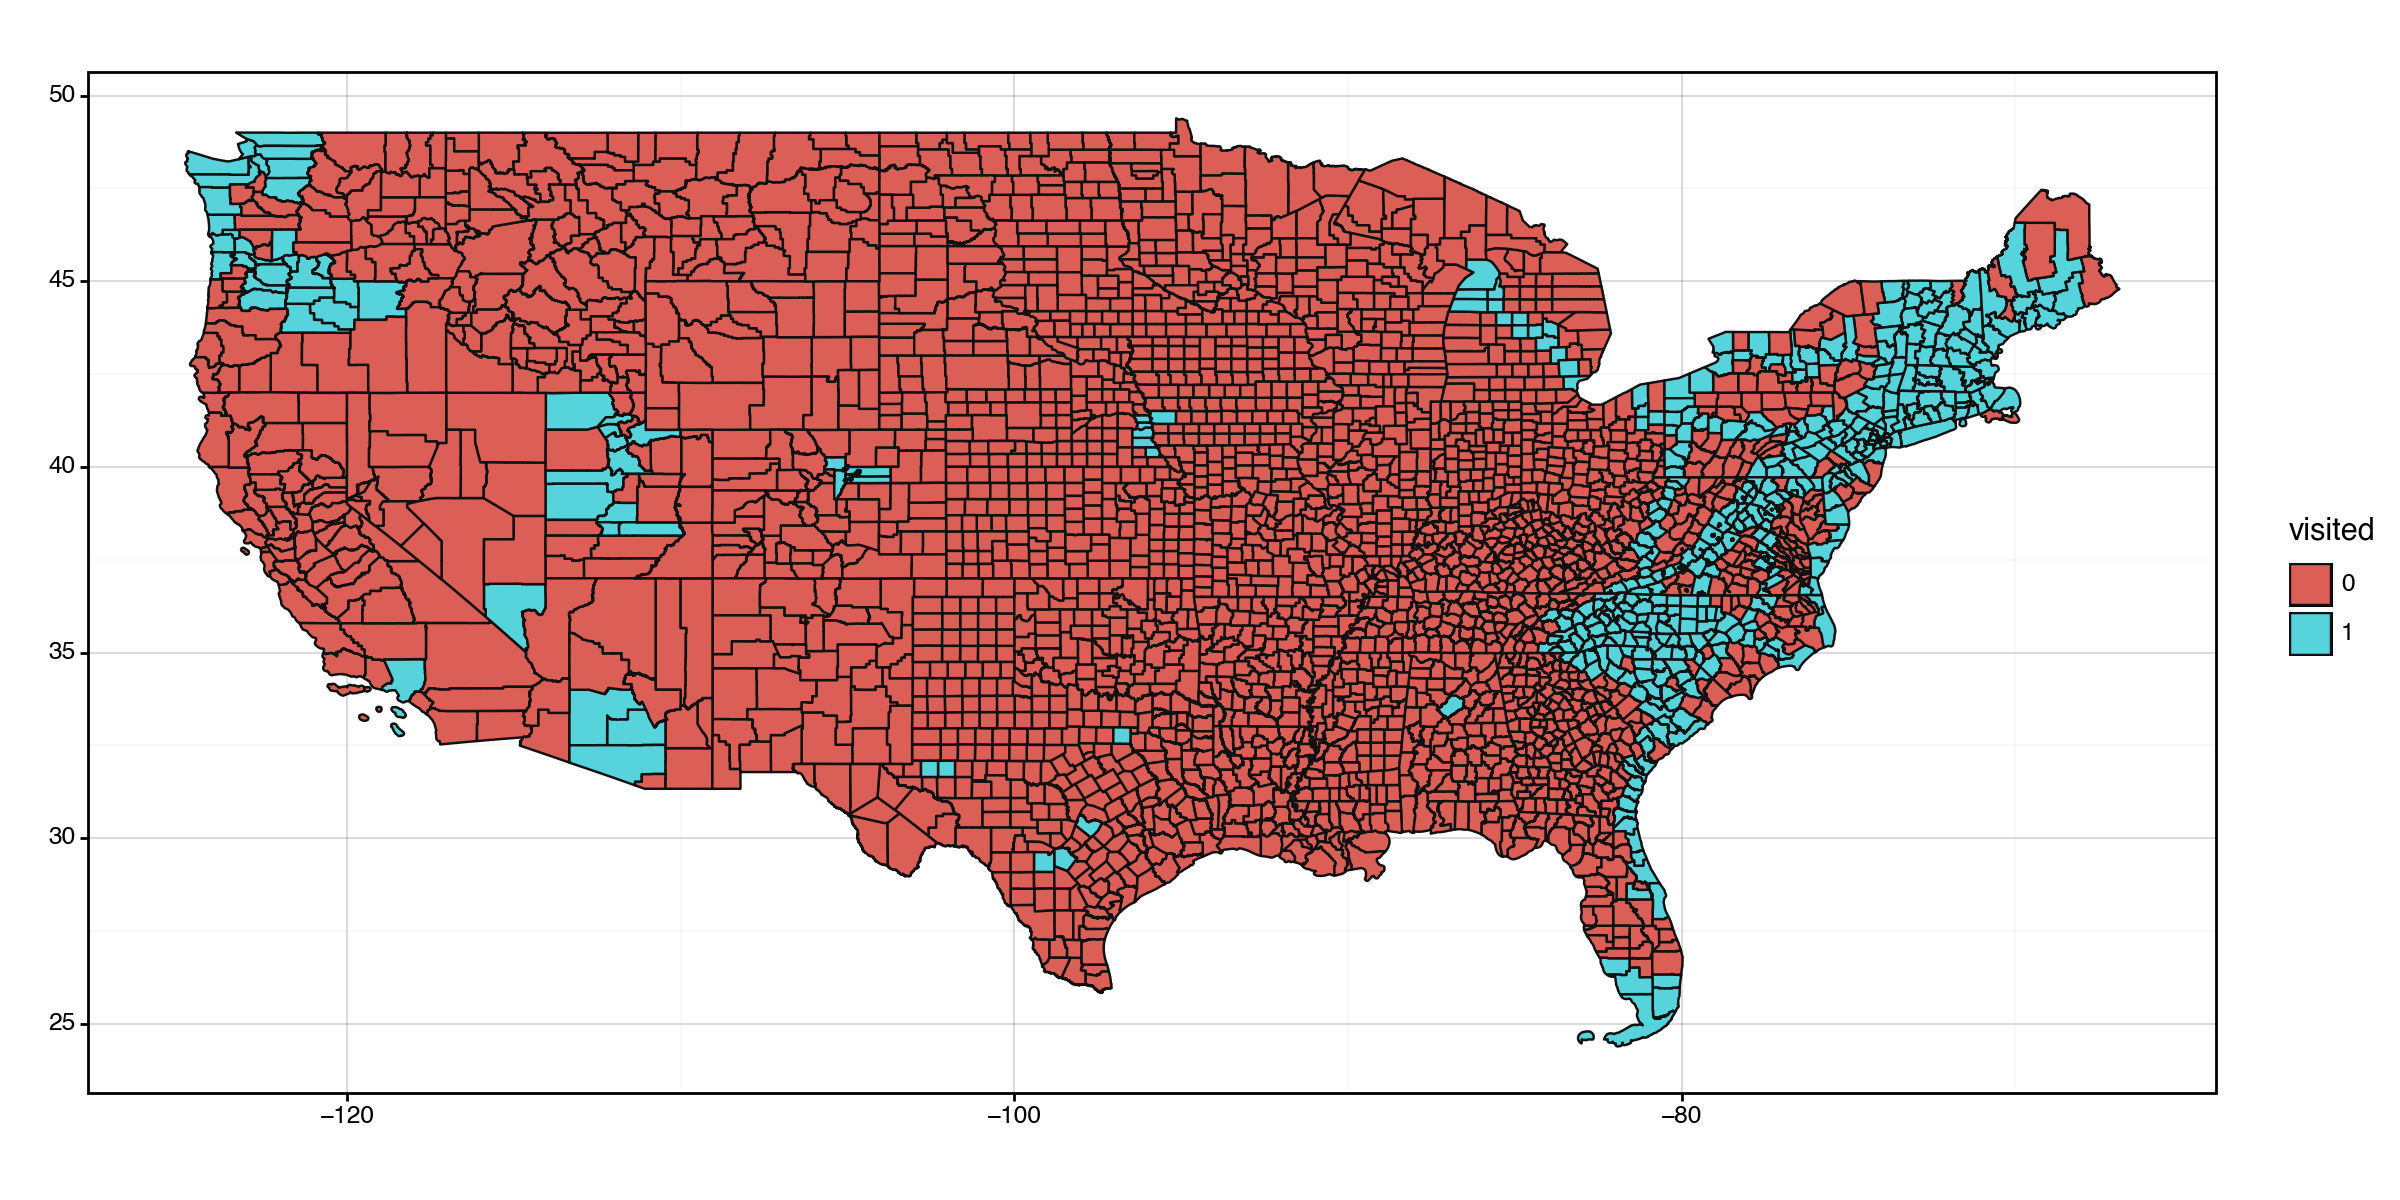

<Figure Size: (1200 x 600)>

In [16]:
p = (
    p9.ggplot(
        data = dct_plot['contiguous'],
        mapping = p9.aes(
            fill = 'visited'
        )
    ) +
    p9.geom_map() +
    p9.theme_linedraw() + 
    p9.theme(
        figure_size=(12,6)
    )
)

p

## Alaska

In [ ]:
p = (
    p9.ggplot(
        data = dct_plot['alaska'],
        mapping = p9.aes(
            fill = 'visited'
        )
    ) +
    p9.geom_map() +
    p9.theme_linedraw() + 
    p9.theme(
        figure_size=(12,6)
    )
)

p

## Hawaii

In [ ]:
p = (
    p9.ggplot(
        data = dct_plot['hawaii'],
        mapping = p9.aes(
            fill = 'visited'
        )
    ) +
    p9.geom_map() +
    p9.theme_linedraw() + 
    p9.theme(
        figure_size=(12,6)
    )
)

p